# Red neuronal recurrente

### Importando las librerias

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Importando los datos de entrenamiento

In [18]:
dataset_train = open("municipios.txt", 'r').read()
# nparray de palabras
training_set = dataset_train.split(" ")
characters = list(set(dataset_train))
char_to_index = { ch:i for i,ch in enumerate(characters) }
index_to_char = { i:ch for i,ch in enumerate(characters) }
print(len(dataset_train))

35530


### Constantes

In [26]:
SEQ_LENGTH = 20
VOCAB_SIZE = len(characters)
N_SEQUENCES = int(len(dataset_train)/SEQ_LENGTH)
HIDDEN_DIM = 700 # neuronas por capa
LSTM_LAYERS = 3 # numero de capas
DROPOUT_RATIO = 0.3 # dropout de la primera capa

### Creando la estructura de datos con [SEQ_LENGTH] pasos de tiempo y una salida

In [27]:
X_train = np.zeros((N_SEQUENCES, SEQ_LENGTH, VOCAB_SIZE))
y_train = np.zeros((N_SEQUENCES, SEQ_LENGTH, VOCAB_SIZE))
for i in range(0, N_SEQUENCES):
    X_sequence = dataset_train[i*SEQ_LENGTH: (i+1)*SEQ_LENGTH]
    X_sequence_index = [char_to_index[value] for value in X_sequence]
    input_sequence = np.zeros((SEQ_LENGTH, VOCAB_SIZE))
    for j in range(SEQ_LENGTH):
        input_sequence[j][X_sequence_index[j]] = 1
    X_train[i] = input_sequence
    
    y_sequence = dataset_train[i*SEQ_LENGTH+1: (i+1)*SEQ_LENGTH+1]
    y_sequence_index = [char_to_index[value] for value in y_sequence]
    target_sequence = np.zeros((SEQ_LENGTH, VOCAB_SIZE))
    for j in range(SEQ_LENGTH):
        target_sequence[j][y_sequence_index[j]] = 1
    y_train[i] = target_sequence

### Reshape

In [5]:
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Construyendo la red neuronal recurrente

In [31]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation

def build_rnn():
    # Inicializando la red
    model = Sequential()
    
    #Añadiendo la primera LSTM
    model.add(LSTM(
        units = HIDDEN_DIM, 
        return_sequences = True,             # Pasa las secuencias a la siguiente capa encolada LSTM
        input_shape = (None, VOCAB_SIZE)     # Tamaño de la entrada
    ))
    model.add(Dropout(DROPOUT_RATIO))
    
    for i in range(LSTM_LAYERS - 1):
        #Añadiendo las demas LSTM
        model.add(LSTM(
            units = HIDDEN_DIM,                          # 50 neuronas
            return_sequences = True              # Pass
        ))
    #regressor.add(Dropout(0.2))              # 20% dropout
    model.add(TimeDistributed(Dense(VOCAB_SIZE)))
    model.add(Activation("softmax"))
    
    # Compilando la red
    model.compile(
        optimizer = 'rmsprop', 
        loss = 'categorical_crossentropy'
    )
    return model

### Entrenamiento

In [13]:
regressor = build_rnn()
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1198/1198 [==============================] - 34s 29ms/step - loss: 0.0533
Epoch 2/100
1198/1198 [==============================] - 29s 24ms/step - loss: 0.0065
Epoch 3/100
1198/1198 [==============================] - 29s 24ms/step - loss: 0.0049
Epoch 4/100
1198/1198 [==============================] - 28s 23ms/step - loss: 0.0054
Epoch 5/100
1198/1198 [==============================] - 30s 25ms/step - loss: 0.0053
Epoch 6/100
1198/1198 [==============================] - 29s 24ms/step - loss: 0.0046
Epoch 7/100
1198/1198 [==============================] - 30s 25ms/step - loss: 0.0049
Epoch 8/100
1198/1198 [==============================] - 30s 25ms/step - loss: 0.0051
Epoch 9/100
1198/1198 [==============================] - 29s 24ms/step - loss: 0.0039
Epoch 10/100
1198/1198 [==============================] - 27s 23ms/step - loss: 0.0044
Epoch 11/100
1198/1198 [==============================] - 28s 23ms/step - loss: 0.0041
Epoch 12/100
1198/1198 [============================

### Haciendo predicciones

In [15]:
# Obteniendo los datos verdaderos del 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Obteniendo las predicciones
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80): # 20 finantial days
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Visualizando los resultados

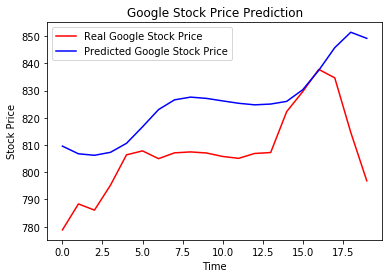

In [20]:
plt.plot(real_stock_price, color = 'red', label = "Real Google Stock Price")
plt.plot(predicted_stock_price, color = 'blue', label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()